In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nicks_plot_utils import *
import numpy as np
from scipy.interpolate import interp1d

from maid_interface import maid_2007_Npi  as maid

E0 = 4.81726  
EK = 5.499

In [2]:
change_theta = {
        -0.9: -1.0,
        -0.7: -0.8,
        -0.5: -0.6,
        -0.3: -0.4,
        -0.1: -0.2,
        0.1:  0.0,
        0.3:  0.2,
        0.5:  0.4,
        0.7:  0.6,
        0.9:  0.8,
        0.525: np.nan,
        0.575: np.nan,
        0.625: np.nan,
        0.675: np.nan,
        0.725: np.nan, 
        0.775: np.nan,
        0.825: np.nan,
        0.875: np.nan,
        0.925: np.nan, 
        0.975: np.nan,
    }

w_bins = np.array([1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3,
                   1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52,
                   1.54, 1.56, 1.58, 1.605, 1.615, 
            1.625, 
            1.635, 
            1.645, 
            1.655, 
            1.665, 
            1.675, 
            1.685,
            1.695, 
            1.705, 
            1.715, 
            1.725, 
            1.735, 
            1.745, 
            1.755, 
            1.765, 
            1.775,
            1.78,])

q2_bins = np.array([1.1, 1.30, 1.56, 1.8, 2.2, 2.6, 3.5])

theta_bins = np.array([-1.0, -0.8, -0.6, -0.4, -0.2,
                       0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

class getXsections:
    """getXsections

    Downloads cross section information from https://clas.sinp.msu.ru/cgi-bin/jlab/db.cgi and parses into dataframes

    Only tested for getting cross sections currently. Not fulling working API for the website.
    """

    def __init__(self, filename):
        self._url = filename
        with open(filename) as file:
            text = file.read()
        self._text = text

    def parseDataSets(self):
        start_lines = []
        lines = self._text.split("\n")
        for n, line in enumerate(lines):
            if "Measurement " in line:
                start_lines.append(n)
        start_lines.append(len(lines))
        self._datasets = []
        for s, start in enumerate(start_lines[:-1]):
            end = start_lines[s + 1] - 1
            self._datasets.append(dataset(lines[start:end]))
            

    @property
    def text(self):
        return self._text

    @property
    def datasets(self):
        return self._datasets

class dataset:
    """
    Class with 
    """

    def __init__(self, text):
        super().__init__()
        # Full text of the dataset
        self._text = text
        # Dict of info from the headers
        self._experiment = {
            "Measurement": None,
            "Title": None,
            "Spokespersons": None,
            "Year": None,
            "Q^2 range": None,
            "Q2_min": None,
            "Q2_max": None,
            "W range": None,
            "W_min": None,
            "W_max": None,
            "E_beam": None,
            "coloumnNamesWithUnits": None,
            "coloumnNames": None,
        }

        self.dataFrame = None
        self.parseText()

    def parseText(self):
        # Parse through header to fill experiment info
        for key, value in self._experiment.items():
            # Fill dict based on header info
            for i, line in enumerate(self._text[0:20]):
                if "Data" in line:
                    data_line = i
                if key in line:
                    key_location = int(line.find(key) + len(key) + 1)
                    self._experiment[key] = line[key_location:].strip("\r")
                    
        # Cleanup names and units rows and split to make arrays
        names = self._text[data_line].strip("\r").strip("\n").split("\t")
        units = self._text[data_line + 1].strip("\r").strip("\n").split("\t")
        coloumnNamesWithUnits = []
        coloumnNames = []
        for n, u in zip(names, units):
            coloumnNamesWithUnits.append(f"{n} [{u}]")
            coloumnNames.append(f"{n}")
        self._experiment["coloumnNamesWithUnits"] = coloumnNamesWithUnits
        self._experiment["coloumnNames"] = coloumnNames
        
        all_data = []
        for data in self._text[data_line + 2:]:
            split_data = data.strip("\r").split("\t")
            if "" in split_data:
                replace = split_data.index("")
                split_data[replace] = "nan"
            all_data.append(np.array(split_data).astype(float))

        self.dataFrame = pd.DataFrame(
            all_data, columns=self.experiment["coloumnNames"])
    @property
    def experiment(self):
        return self._experiment

def get_maid_values(xs, w, q2, theta, ENERGY=E0):
    crossSections = []
    for phi in xs:
        crossSections.append(maid(ENERGY, w, q2, theta, np.degrees(phi)))
        
    return np.array(crossSections)

def plot_maid_model(ax, w, q2, theta, xs, fmt='.', ENERGY=E0):
    # Get bin centers
    #_w = (w.left + w.right) / 2.0
    #_q2 = (q2.left + q2.right) / 2.0
    #_theta = (theta.left + theta.right) / 2.0
    # Get the cross section values from maid
    crossSections = get_maid_values(xs, w, q2, theta, ENERGY)
    #_ax = ax.twinx()
    ax.errorbar(xs, crossSections, fmt=fmt, alpha=0.5)
    #_ax.set_ylim(bottom=0, top=np.max(crossSections)*1.5)

    return np.array(crossSections)

In [3]:
data = getXsections("/Users/tylern/scratch/code/xsec/file.out")
data.parseDataSets()

data.datasets[0].dataFrame.columns

Index(['W', 'Q^2', 'Beam energy', 'cos(theta)', 'phi', 'dsigma/dOmega',
       'Data errors', 'Systematic errors'],
      dtype='object')

In [4]:
frames = []
for sets in data.datasets:
    for cos_t in sets.dataFrame["cos(theta)"].unique():
        cut = (sets.dataFrame["cos(theta)"] == cos_t)

        x = np.radians(sets.dataFrame[cut]["phi"])
        y = sets.dataFrame[cut]["dsigma/dOmega"]
        # yerr = np.sqrt(sets.dataFrame[cut]["Data errors"]**2 + sets.dataFrame[cut]["Systematic errors"]**2)
        yerr = sets.dataFrame[cut]["Data errors"]
        w_left = sets.dataFrame['W']
        q2_left = sets.dataFrame['Q^2']
        cos_t_left = change_theta[cos_t]
        
        frames.append(pd.DataFrame({
            "experiment" : "kijun",
            "W_min": w_left,
            "Q2_min": q2_left,
            "cos_t": cos_t_left,
            "phi": x,
            "y": y,
            "yerr": yerr
        }))

In [5]:
xsecx = pd.concat(frames)
xsecx.dropna(inplace=True)

print(xsecx['W_min'].unique())
print(xsecx['Q2_min'].unique())

print(len(xsecx))

xsecx.to_csv("overlap_data_test_2.csv", index=False, header=False)

[1.605 1.615 1.625 1.635 1.645 1.655 1.665 1.675 1.685 1.695 1.705 1.715
 1.725 1.735 1.745 1.755 1.765 1.775 1.78  1.83  1.89  1.95  2.01 ]
[1.8  2.2  2.6  3.15 4.  ]
14776


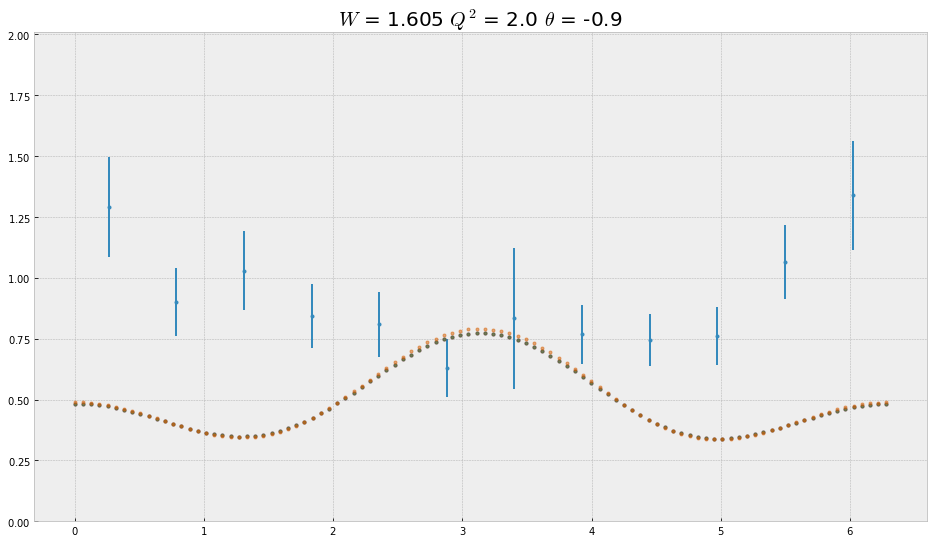

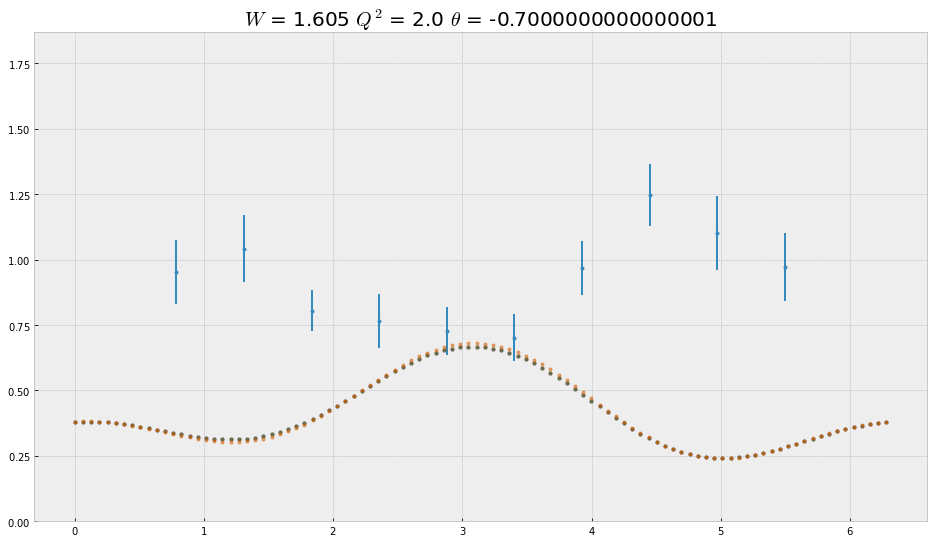

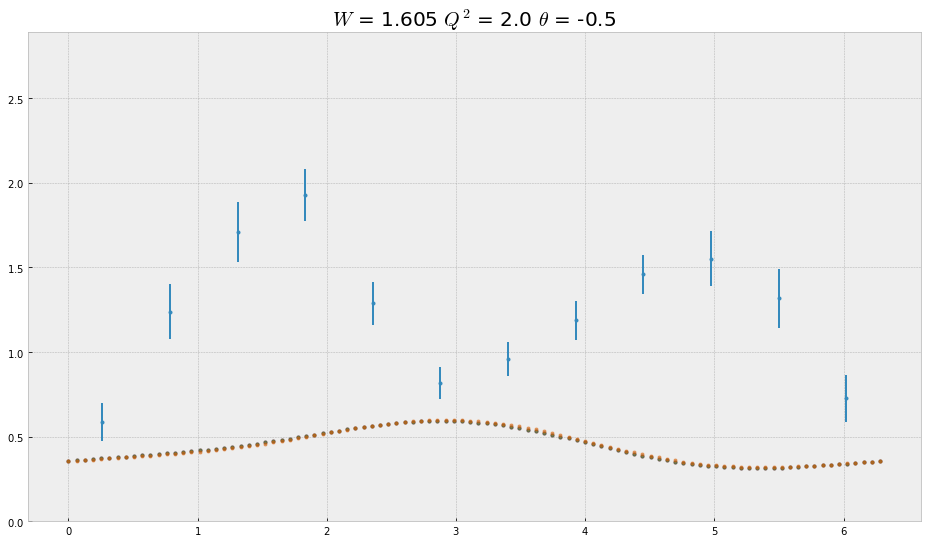

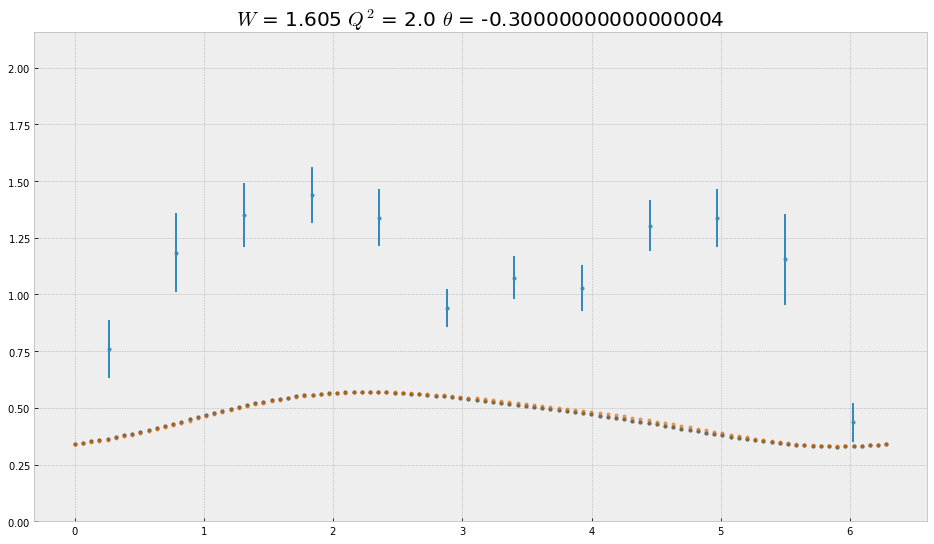

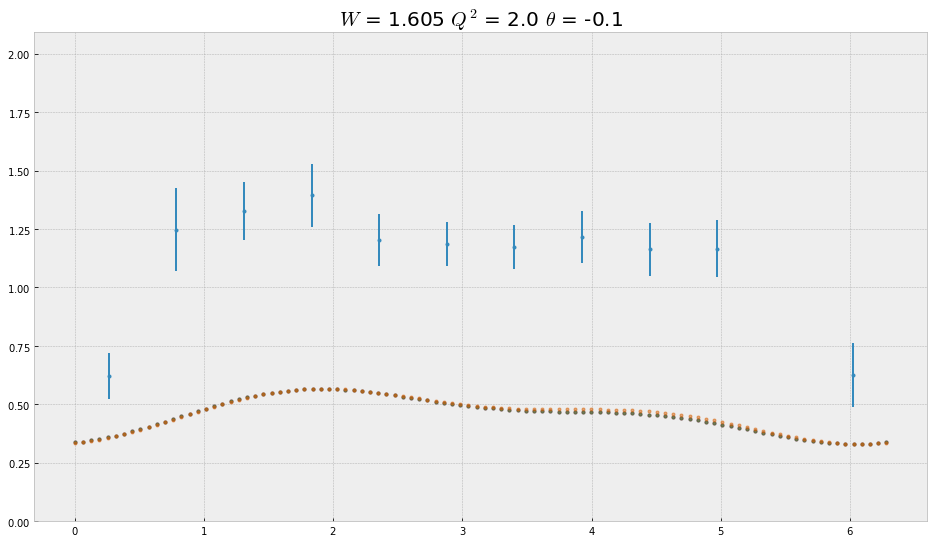

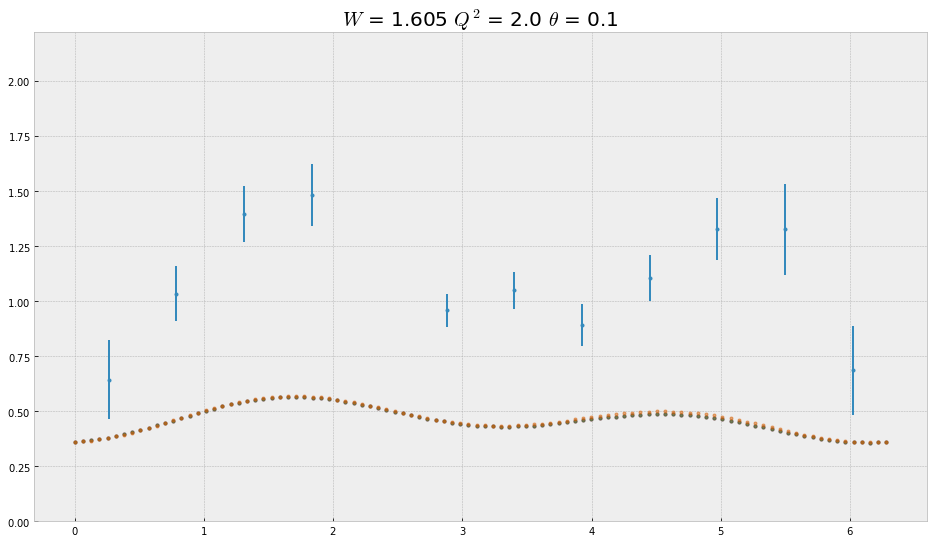

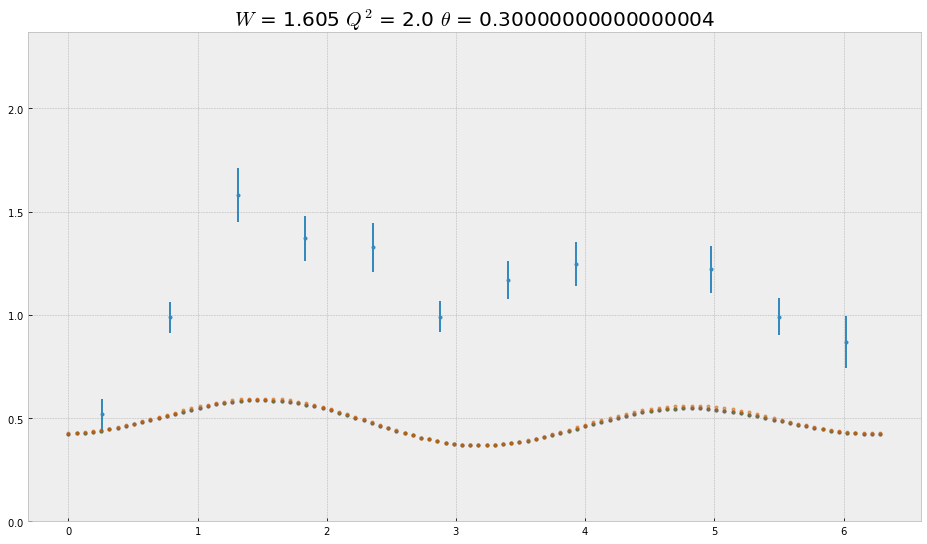

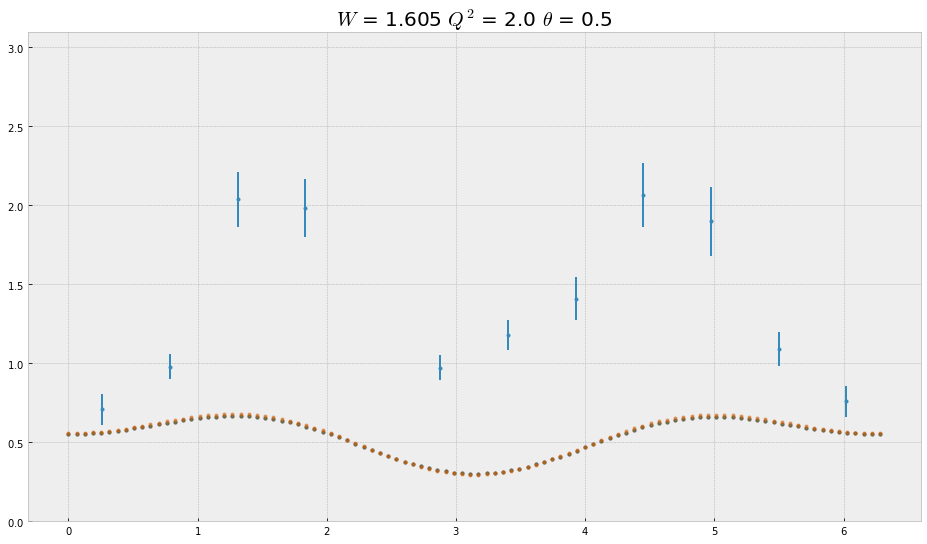

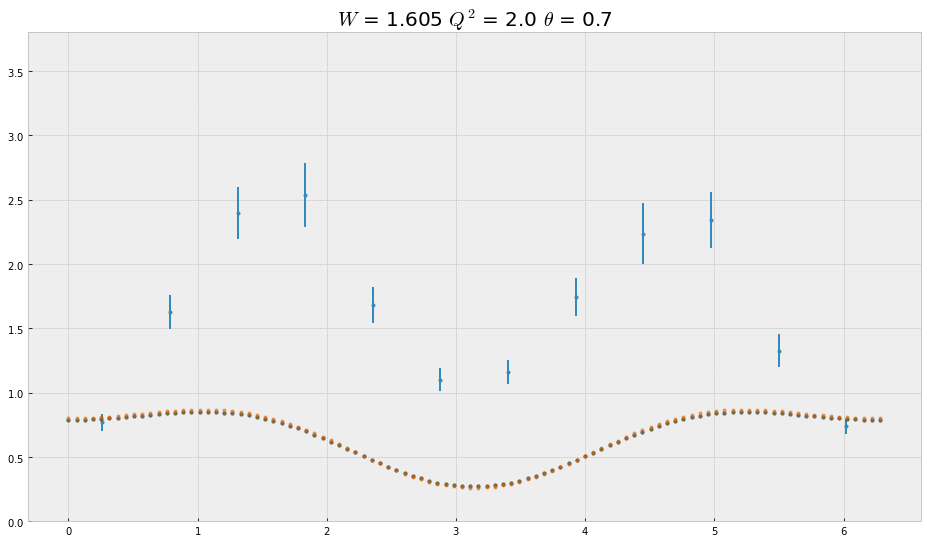

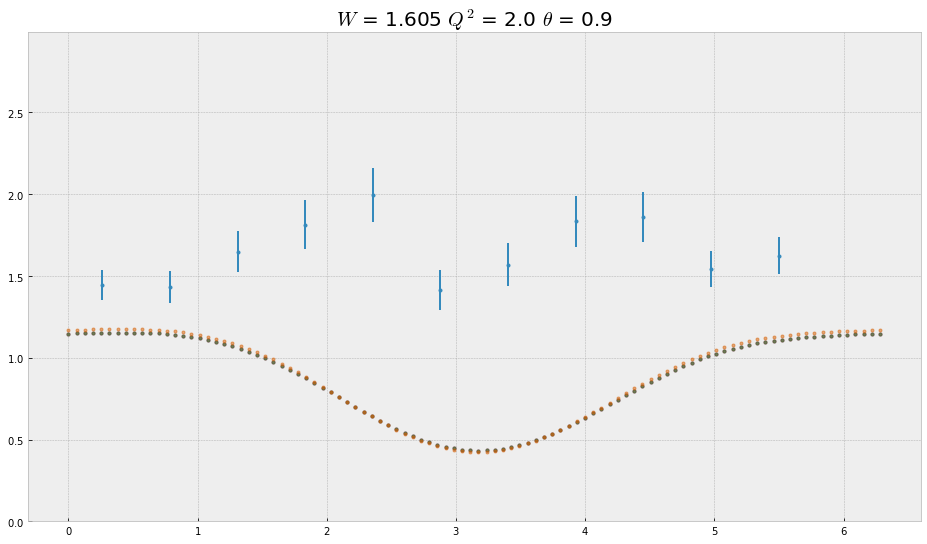

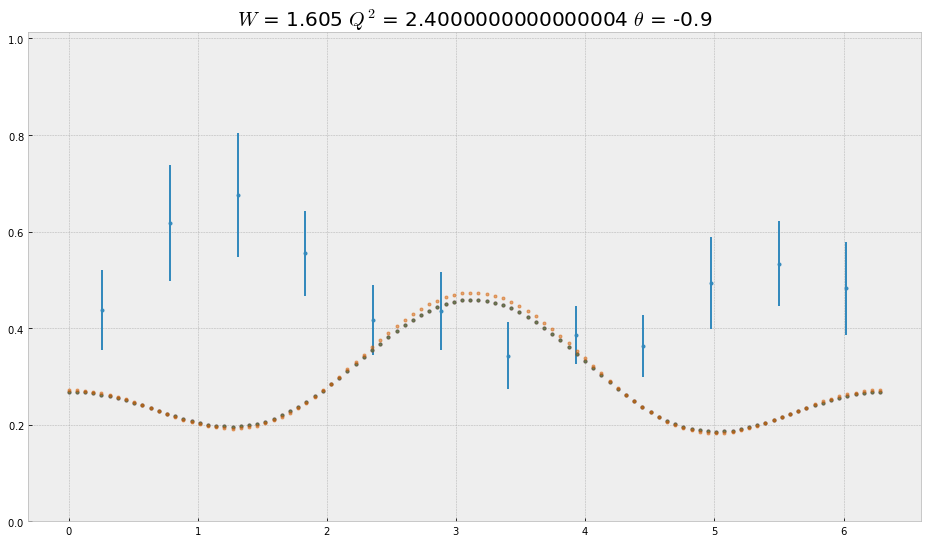

In [6]:
xs = np.linspace(0,2*np.pi,100)
num_plot = 0
for w in w_bins:
    for q2 in q2_bins:
        for theta in theta_bins:
            if num_plot > 10:
                break
            xsec = xsecx[(xsecx.cos_t == theta) & (xsecx.W_min == w) & (xsecx.Q2_min == q2)]
            if len(xsec) == 0:
                continue
                
            fig, ax = plt.subplots()
            ax.errorbar(xsec.phi, xsec.y, yerr=xsec.yerr, fmt='.')
            t = (theta + theta + 0.2)/2
            
            plot_maid_model(ax, w, q2+0.2, t, xs, fmt='.', ENERGY=E0)
            plot_maid_model(ax, w, q2+0.2, t, xs, fmt='.', ENERGY=E0)
            plot_maid_model(ax, w, q2+0.2, t, xs, fmt='.', ENERGY=E0)
            plot_maid_model(ax, w, q2+0.2, t, xs, fmt='.', ENERGY=EK)
            ax.set_ylim(bottom=0, top=np.max(xsec.y)*1.5)
            
            plt.title(f"$W$ = {w} $Q^2$ = {q2+0.2} $\\theta$ = {t}")
            plt.show()
            num_plot += 1